In [264]:
import argparse
import glob
import os
import sys

import pandas as pd
import seaborn as sns

sys.path.insert(0, "..")

from pytorch_adapt.models import pretrained_src_accuracy, pretrained_target_accuracy

from powerful_benchmarker.utils.constants import add_default_args
from validator_tests.eval_validators import (
    _get_best_accuracy_per_adapter,
    _get_correlation,
    group_by_task_validator,
)
from validator_tests.utils import create_main
from validator_tests.utils.constants import TARGET_ACCURACY, add_exp_group_args
from validator_tests.utils.df_utils import (
    get_name_from_df,
    task_name_split,
    unify_validator_columns,
)
from validator_tests.utils.plot_val_vs_acc import _scatter_plot, scatter_plot

In [265]:
def domain_len(dataset, domain, split):
    x = {
        "mnist": {
            "mnist": {"train": 60000, "val": 10000},
            "mnistm": {"train": 59001, "val": 9001},
        },
        "office31": {
            "amazon": {"train": 2253, "val": 564},
            "dslr": {"train": 398, "val": 100},
            "webcam": {"train": 636, "val": 159},
        },
        "officehome": {
            "art": {"train": 1941, "val": 486},
            "clipart": {"train": 3492, "val": 873},
            "product": {"train": 3551, "val": 888},
            "real": {"train": 3485, "val": 872},
        },
    }
    return x[dataset][domain][split]


def adapter_names():
    return [
        "ATDOCConfig",
        "BNMConfig",
        "BSPConfig",
        "CDANConfig",
        "DANNConfig",
        "GVBConfig",
        "IMConfig",
        "MCCConfig",
        "MCDConfig",
        "MMDConfig",
    ]

In [283]:
def get_correlation_df():
    files = glob.glob(
        "../tables/**/weighted_spearman_0.0_src_threshold_per_adapter.pkl"
    )
    assert len(files) == 19
    df = []
    for f in files:
        curr_df = pd.read_pickle(f)
        curr_df = pd.melt(
            curr_df,
            id_vars=["validator", "validator_args", "task"],
            value_vars=adapter_names(),
            var_name="adapter",
            value_name="weighted_spearman_correlation",
        )

        dataset, src_domain, target_domain = task_name_split(curr_df.task.unique()[0])
        [src_train_len, src_val_len] = [
            domain_len(dataset, src_domain, x) for x in ["train", "val"]
        ]
        [target_train_len] = [domain_len(dataset, target_domain, x) for x in ["train"]]
        [p_src_train_acc, p_src_val_acc] = [
            pretrained_src_accuracy(dataset, [src_domain], x, "micro")
            for x in ["train", "val"]
        ]
        [p_target_train_acc] = [
            pretrained_target_accuracy(
                dataset, [src_domain], [target_domain], x, "micro"
            )
            for x in ["train"]
        ]
        curr_df["src_train_len"] = src_train_len
        curr_df["src_val_len"] = src_val_len
        curr_df["target_train_len"] = target_train_len
        curr_df["train_len_diff"] = target_train_len - src_train_len
        curr_df["val_len_diff"] = target_train_len - src_val_len
        curr_df["train_len_rel_diff"] = target_train_len / src_train_len
        curr_df["val_len_rel_diff"] = target_train_len / src_val_len
        curr_df["pretrained_val_diff"] = p_target_train_acc - p_src_val_acc
        curr_df["pretrained_src_train_acc"] = p_src_train_acc
        curr_df["pretrained_src_val_acc"] = p_src_val_acc
        curr_df["pretrained_target_train_acc"] = p_target_train_acc
        curr_df["pretrained_train_diff"] = p_target_train_acc - p_src_train_acc
        curr_df["pretrained_val_diff"] = p_target_train_acc - p_src_val_acc
        curr_df = unify_validator_columns(
            curr_df, new_col_name="unified_validator", drop_validator_args=False
        )
        curr_df = curr_df[
            ~curr_df["unified_validator"].isin(
                [
                    "Accuracy_average_macro_split_target_train",
                    "Accuracy_average_micro_split_target_train",
                    "Accuracy_average_macro_split_target_val",
                    "Accuracy_average_micro_split_target_val",
                ]
            )
        ]
        ranked = curr_df.groupby(["task", "adapter"])[
            "weighted_spearman_correlation"
        ].rank(method="min", ascending=False)
        curr_df = curr_df[ranked <= 1]
        df.append(curr_df)

    df = pd.concat(df, axis=0)
    df = df[df["task"] != "mnist_mnist_mnistm"]
    return df

In [284]:
def get_best_acc_df():
    files = glob.glob("../tables/**/best_accuracy_per_adapter_1.pkl")
    assert len(files) == 19
    df = []
    for f in files:
        curr_df = pd.read_pickle(f)
        df.append(curr_df)

    df = pd.concat(df, axis=0)
    df = df[df["task"] != "mnist_mnist_mnistm"]
    df = df.drop(columns=[f"{TARGET_ACCURACY}_std"])
    return df

In [285]:
df = get_correlation_df()
acc_df = get_best_acc_df()
df = df.merge(acc_df)
df = df.rename(columns={TARGET_ACCURACY: "best_true_acc"})

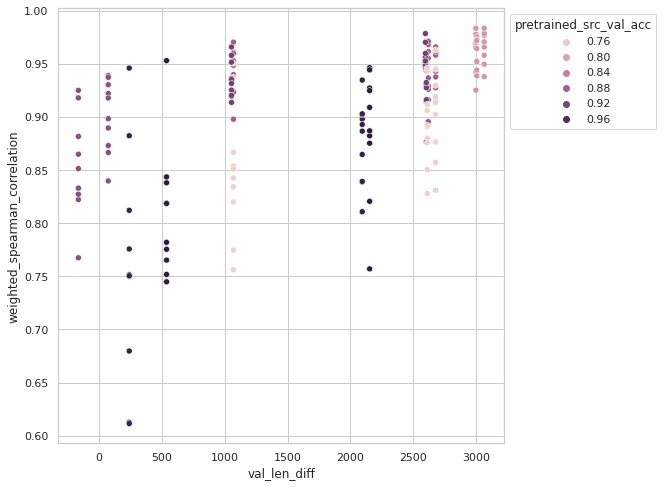

In [292]:
# curr_df = df[df["adapter"] == "GVBConfig"]
# curr_df = df[df["task"].str.startswith("officehome")]
curr_df = df
sns.set(style="whitegrid", rc={"figure.figsize": (8, 8)})
plot = sns.scatterplot(
    data=curr_df,
    x="val_len_diff",
    y="weighted_spearman_correlation",
    hue="pretrained_src_val_acc",
)
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))